# Prediction Competition

The goal of machine learning is to build models with high predictive accuracy. Thus, it is not surprising that there exist machine learning competitions, where participants compete to build the model with the lowest possible prediction error.

[Kaggle](http://www.kaggle.com/) is a website that hosts machine learning competitions. In this lab, you will participate in a Kaggle competition with other students in this class! The top 5 people will earn up to 5 bonus points on this lab. To join the competition, visit [this link](https://www.kaggle.com/c/beer2019). You will need to create an account on Kaggle first.

# Question

Train many different models to predict IBU. Try different subsets of variables. Try different machine learning algorithms (you are not restricted to just $k$-nearest neighbors). At least one of your models must contain variables derived from the `description` of each beer. Use cross-validation to systematically select good models and submit your predictions to Kaggle. You are allowed 2 submissions per day, so submit early and often!

Note that to submit your predictions to Kaggle, you will need to export your predictions to a CSV file (using `.to_csv()`) in the format expected by Kaggle (see `beer_test_sample_submission.csv` for an example).

# Discovery

In [87]:
import pandas as pd, numpy as np
%matplotlib inline

beer_df = pd.read_csv("/data301/data/beer/beer_train.csv")
beer_df = beer_df.drop(["id"], axis=1)

In [88]:
beer_df.description = beer_df.description.fillna("").str.lower()
beer_df.name = beer_df.name.fillna("").str.lower()
beer_df.srm = beer_df.srm.replace("Over 40", 41).astype(int)
beer_df.available = beer_df.available.astype('category')
beer_df.glass = beer_df.glass.astype('category')
beer_df.isOrganic = beer_df.isOrganic.astype('category')
beer_df.head()

,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,8.2,"Available at the same time of year, every year.",a belgian-abbey-style tripel that is big in al...,NaN,31.0,N,loonytoontripel,1.070,8
1,5.7,"Available at the same time of year, every year.",covert hops is a crafty ale. its stealthy dark...,Pint,45.0,N,covert hops,1.056,35
2,5.8,"Available at the same time of year, every year.",this is a traditional german-style marzen char...,Mug,25.0,N,oktoberfest,1.048,10
3,5.5,Available year round as a staple beer.,a west coast-style pale ale balancing plenty o...,Pint,55.0,N,pale ale,1.044,5
4,4.8,Available year round as a staple beer.,this bombshell has a tantalizing crisp and cle...,Pint,11.4,N,head turner blonde ale,1.045,3


My first step is my process was to clean all the features. For SRM, the number of "Over 40" observations was much greater than the number of observations with a value actually over 40, so I decided that I would simply replace them with a value of "41" since I couldn't really impute the values based on similar beers easily.

In [89]:
beer_df.dtypes

abv                 float64
available          category
description          object
glass              category
ibu                 float64
isOrganic          category
name                 object
originalGravity     float64
srm                   int64
dtype: object

Here we can see that all our type conversion were correct, and our data is mostly ready for training.

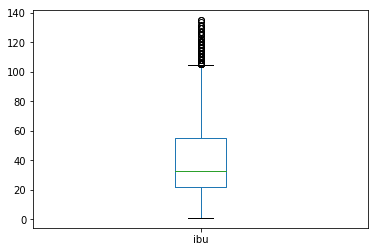

In [90]:
beer_df = beer_df[beer_df.ibu <= 
                  beer_df.ibu.quantile(.997)]
beer_df.ibu.plot.box()

I wanted to take a look at the distribution of beer ibu's to see if it was close enough to normal or not. I discovered there were 1 or 2 problematic outliers, therefore I kept all the data within the 99.7th percentile

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f106ade8b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f106aa2bc88>]], dtype=object)

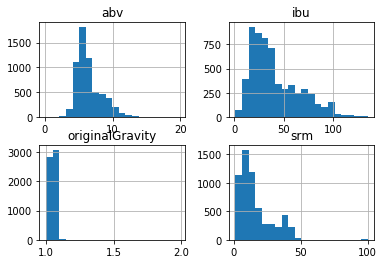

In [91]:
beer_df.hist(bins=20)

Here's histograms of our numerical data, and it appears that our features are some right skewed. We will transform them.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f106b07cef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f106a8508d0>]], dtype=object)

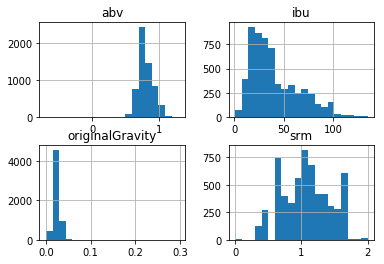

In [92]:
beer_df.abv = np.log10(beer_df.abv)
beer_df.srm = np.log10(beer_df.srm)
beer_df.originalGravity = np.log10(
beer_df.originalGravity)
beer_df.hist(bins=20)

I observed that log transforming our data helped make it more normally distributed, and that should help slightly when training our model.

In [93]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

X_dict = (beer_df[["abv", "available", 
                  "originalGravity", "srm"]]
          .to_dict(orient="records"))
y = beer_df["ibu"]
vec = DictVectorizer(sparse=False)
scaler = RobustScaler()
model = KNeighborsRegressor(n_neighbors=20)
pipeline = Pipeline([("vectorizer", vec), 
                     ("scaler", scaler), 
                     ("fit", model)])

In [94]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer

def true_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
my_rmse = make_scorer(true_rmse, greater_is_better=True)

kf = KFold(5, shuffle=True, random_state=5).get_n_splits(X_dict)
scores = cross_val_score(pipeline, X_dict, y, 
                         cv=kf, scoring=my_rmse)
scores.mean()

17.914969314662962

I went with a basic approach with KNearest on only a few features at first in order to get a baseline, later we will use more complex modelling.

### Extracting Features and More

I needed to extract key information from the textual data given to us, and so I decided to use the TFIDF method, while also removing stop words present in the corpus of beer text

In [95]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = beer_df.drop("ibu", axis=1)
y = beer_df["ibu"]
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size=.05))

In [96]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin, clone

class ColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.cols]

class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()
    
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
))

I also needed a way to use complex scikit-learn pipelines with pandas, and it proved to be somewhat difficult at first (without ColumnTransformer, which my version of sklearn did not have). I eventually was able to get it to handle all my data, with a few methods: ColSelector, Converter, and StringIndexer.

In [107]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

full_pipe = Pipeline([
    ("selector", ColSelector(cols=X.columns.values)),
    ("features", FeatureUnion(transformer_list=[
        ("categorical_pipe", Pipeline([
            ("selector", ColSelector(cols=[
                "available",
                "glass",
                "isOrganic"])),
            ("indexer", StringIndexer()),
            ("encoder", OneHotEncoder(
                handle_unknown='ignore'))
        ])),
        ("numeric_pipe", Pipeline([
            ("selector", ColSelector(cols=[
                "abv",
                "originalGravity",
                "srm"])),
            ("scaler", RobustScaler()),
        ])),
        ("name_pipe", Pipeline([
            ("selector", ColSelector(cols=[
                "name"])),
            ("converter", Converter()),
            ("vectorizer", TfidfVectorizer(
                stop_words='english'))
        ])),
        ("description_pipe", Pipeline([
            ("selector", ColSelector(cols=[
                "description"])),
            ("converter", Converter()),
            ("vectorizer", TfidfVectorizer(
                stop_words='english',
                sublinear_tf=True))
        ]))
    ])),
    ("regressor", GradientBoostingRegressor(
        random_state=5))
])

From my testing, I decided to go with an already implemented ensemble method, GradientBoostingRegressor. I tried implementing my own stacked model with many linear and non-linear models, but this turned out to be only slightly better but took ages to train. I also tried keras with a deep(ish) neural network, and it proved better than most linear sklearn models, but not as good as sklearn ensemble methods (RandomForest, GradientBoost, etc).

In [98]:
pg = {
    "features__name_pipe__vectorizer__norm": ["l2"],
    "features__name_pipe__vectorizer__ngram_range": [(1, 1)],
    "features__name_pipe__vectorizer__sublinear_tf": [True],
    "features__description_pipe__vectorizer__norm": ["l2"],
    "features__description_pipe__vectorizer__ngram_range": [(1, 1)],
    "regressor__n_estimators": [500],
    "regressor__min_samples_leaf": [5],
    "regressor__loss": ["huber"]
}

regression_model = GridSearchCV(full_pipe, pg, cv=5, scoring=my_rmse)
regression_model.fit(X_train, y_train)
regression_model.best_params_

{'features__description_pipe__vectorizer__ngram_range': (1, 1),
 'features__description_pipe__vectorizer__norm': 'l2',
 'features__name_pipe__vectorizer__ngram_range': (1, 1),
 'features__name_pipe__vectorizer__norm': 'l2',
 'features__name_pipe__vectorizer__sublinear_tf': True,
 'regressor__loss': 'huber',
 'regressor__min_samples_leaf': 5,
 'regressor__n_estimators': 500}

From gridsearching, I was able to compare many different parameters to see which gave me the best performance and score.

In [99]:
print("Mean CV Score:", regression_model.cv_results_["mean_test_score"][0]) # 14.2
print("Test Score:", regression_model.score(X_test, y_test))# 13.2

Mean CV Score: 14.3413110374
Test Score: 13.6237123243


An improvement of around 2-3 points from KNearest is what we were looking for, and that is what we got!

In [109]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y_pred = regression_model.predict(X_test)
(pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    .plot.scatter(x="Actual", y="Predicted"))
plt.text(x=100, y=15, s="$R^2$ = {:3.2f}".format(r2_score(y_test, y_pred)))

ValueError: array length 4753 does not match index length 300

A scatterplot of our predictions versus their true values will give us view of how well our predictions were correlated with their true values. We would ideally want a strong relationship (high r2), but it is difficult to achieve that for our problem. We see that our model does pretty well for beers on the lower ibu spectrum, but then doesn't do so well on predicting beers with ibus greater than around 60.

# Prediction

For prediction on our test data, we will do everything we did for our training data the same, except we **can't** train on it, only predict. We will also apply the same transformations on the numerical features on the test data as we did on the training data.

In [101]:
test_df = pd.read_csv("/data301/data/beer/beer_test.csv")
test_ids = test_df["id"]
test_df = test_df.drop(["id"], axis=1)

In [102]:
test_df.description = test_df.description.fillna("").str.lower()
test_df.name = test_df.name.fillna("").str.lower()
test_df.srm = test_df.srm.replace("Over 40", 41).astype(float)
test_df.available = test_df.available.astype('category')
test_df.glass = test_df.glass.astype('category')
test_df.isOrganic = test_df.isOrganic.astype('category')
test_df.head()

,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,10.0,Limited availability.,a classic belgian trappist style strong ale wi...,Tulip,NaN,N,she will!,1.084,17.0
1,5.2,Available year round as a staple beer.,an american-style of pale ale brewed with a ba...,Pint,NaN,N,defender american pale ale,1.044,22.0
2,4.0,Available during the winter months.,"this amber wheat ale has a balanced malt body,...",Tulip,NaN,Y,hazel,1.036,19.0
3,10.2,Available year round as a staple beer.,a uniquely large beer developed by taking our ...,Pint,NaN,N,cinderella’s twin double ipa,1.087,11.0
4,6.0,Limited availability.,an american red ale with crisp hop flavor.,NaN,NaN,N,independence ale,1.048,14.0


In [103]:
test_df.dtypes

abv                 float64
available          category
description          object
glass              category
ibu                 float64
isOrganic          category
name                 object
originalGravity     float64
srm                 float64
dtype: object

In [105]:
X_test = test_df.drop("ibu", axis=1)
y_pred = regression_model.predict(X_test)

In [106]:
pred_df = pd.DataFrame({'id': test_ids, 'ibu': y_pred})
pred_df = pred_df.set_index("id")
pred_df.to_csv("full_pred.csv")

# Submission Instructions

Once you are finished, follow these steps:

1. Restart the kernel and re-run this notebook from beginning to end by going to `Kernel > Restart Kernel and Run All Cells`.
2. If this process stops halfway through, that means there was an error. Correct the error and repeat Step 1 until the notebook runs from beginning to end.
3. Double check that there is a number next to each code cell and that these numbers are in order.

Then, submit your lab as follows:

1. Go to `File > Export Notebook As > PDF`.
2. Double check that the entire notebook, from beginning to end, is in this PDF file. (If the notebook is cut off, try first exporting the notebook to HTML and printing to PDF.)
3. Upload the PDF [to PolyLearn](https://polylearn.calpoly.edu/AY_2018-2019/mod/assign/view.php?id=325688).